# Travailler les IRM structurelles en Python

Dans ce notebook, vous apprendrez à charger des IRM en mémoire en utilisant le package NiBabel. Avec ce package, vous pourrez importer et travailler vos images IRM structurelles en utilisant Python. Dans ce tutoriel, nous nous intéressons seulement aux images pondérées T1.

### Sélection du matériel

Avant de commencer nous allons sélectionner le matériel adapté à nos calculs. Le deep learning à besoin de cartes graphiques (GPU) afin de réduire le temps de calculs.

Appuyer sur "Exécution" -> "Modifier le type d'exécution" 

Dans "Accélérateur matériel" sélectionnez GPU puis appuyer sur enregistrer. 

## Données

Dans ce notebook, je vais utiliser essentiellement les images IRM pondérées T1 de la base IXI. 

Vous pouvez aussi télécharger ces données, elles sont disponibles sur ce [site](https://brain-development.org/ixi-dataset/).



## Importer les packages

In [0]:
# Calculs scientifiques
import numpy as np
# Gestion des formats IRM
import nibabel as nib
# Création et affichage de graphiques
import matplotlib.pyplot as plt

## Importer les données

Cliquez sur le lien ci-dessous : 

https://drive.google.com/open?id=1zgPAAfEbn-71oh1GDnfFb5KogU-0zLjm

Cliquer droit sur le dossier data et appuyer sur ajouter à mon drive.

<img src="https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_2/images/data_google_drive.png?raw=1" width="800" >

Exécutez la cellule ci-dessous et appuyer sur le lien proposé. 

Suivez les instructions et copier le code ci-dessous.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Les données sont maintenant dans votre environnement collab.

In [3]:
# La fonction load vous sert à importer vos fichiers
mri_img = nib.load('/content/gdrive/My Drive/tp_2/data/IXI330-Guys-0881-T1.nii.gz')
print(mri_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 256, 150)
affine: 
[[-4.27650400e-02  1.79124363e-02  1.19853210e+00 -8.60915909e+01]
 [-9.36523736e-01 -1.01643954e-19 -5.47492690e-02  1.23196281e+02]
 [ 8.17243592e-04  9.37328815e-01 -2.29040533e-02 -1.15913986e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 150   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         0.9375     0.9375     1.2000005  0.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
c

On voit que notre objet *mri_img* contient beaucoup de données. 

Dans ce tuto on va avoir besoin principalement de deux choses :

- le header ;

- l'image IRM.

La méthode *get_data* nous retourne notre image sous forme d'une matrice 3D. 

Chaque case de cette matrice représente un voxel (pixel en 3D)

Chaque valeur d'un voxel correspond à l'intensité du voxel sur notre image IRM.

In [10]:
# Extraction du header où sont stocker les métadonnées de la matrice
mri_header = mri_img.header
mri_affine = mri_img.affine

# Extraction des données de l'image IRM
mri_matrix = mri_img.get_fdata()

# La fonction shape retourne la dimension de la matrice
print(mri_matrix.shape)

(256, 256, 150)


### Visualisation

Ce code est très pratique pour afficher des coupes de l'image IRM.

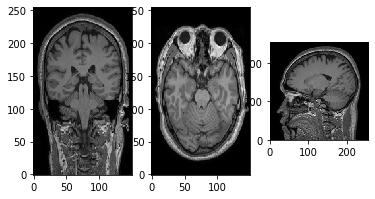

In [39]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

# Visualisation d'une coupe coronale
slice_0 = mri_matrix[150, :, :]

# Visualisation d'une coupe axiale
slice_1 = mri_matrix[:, 120, :]
slice_1 = slice_1.T
slice_1 = np.flip(slice_1,axis=1)


# Visualisation d'une coupe sagittale
slice_2 = mri_matrix[:, :, 90]

show_slices([slice_0.T, slice_1, slice_2])
plt.show()

Bien que l'on peut visualiser certaines coupes avec Python, ce n'est pas le plus optimisé. 

Je vous conseil des logiciels comme Freesurfer qui permettent de bien mieux visualiser vos images. 

## Exemple de traitement : La normalisation

À partir de maintenant on ne va plus considérer l'image IRM comme une image, mais plutôt comme une matrice *numpy*. 

Comme nous avons une matrice, nous pouvons appliquer dessus tous les traitements mathématique que nous souhaitons. 

Imaginons que nous voulons appliquer un algorithme de deep learning sur notre matrice. 

Nous devons d'abord normaliser nos données pour obtenir des données compris entre 0 et 1 afin d'éviter au maximum les problèmes d'exploding et de vanishing gradient. 

In [35]:
print("Intensité minimum : "+str(mri_matrix.min()))
print("Intensité maximum : "+str(mri_matrix.max()))

Intensité minimum : 0.0
Intensité maximum : 1017.0


Nous allons utiliser la min max normalisation :

$$ x'=\frac{x-min(x)}{max(x)-min(x)} $$ 

In [36]:
# min max normalisation de notre matrice
mri_matrix_norm = (mri_matrix - mri_matrix.min()) / (mri_matrix.max() - mri_matrix.min())

print("Intensité minimum : "+str(mri_matrix_norm.min()))
print("Intensité maximum : "+str(mri_matrix_norm.max()))

Intensité minimum : 0.0
Intensité maximum : 1.0


On peut vérifier sur notre image si nos données ont été affectées par cette normalisation.

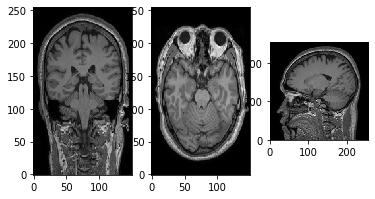

In [40]:
# Visualisation d'une coupe coronale de notre nouvelle matrice
slice_0 = mri_matrix_norm[150, :, :]

# Visualisation d'une coupe axiale de notre nouvelle matrice
slice_1 = mri_matrix_norm[:, 120, :]
slice_1 = slice_1.T
slice_1 = np.flip(slice_1,axis=1)

# Visualisation d'une coupe sagittale de notre nouvelle matrice
slice_2 = mri_matrix_norm[:, :, 90]

show_slices([slice_0.T, slice_1, slice_2])
plt.show()

## Enregistrer votre nouvelle image

Maintenant que vous avez appliquer vos changements à votre image, vous pourriez vouloir sauver cette nouvelle version. 

Si vous voulez sauvegarder votre nouvelle image dans le même espace que votre image d'origine vous aurez besoin d'utiliser les informations stockées dans son *header*.

In [0]:
# Nom de votre nouveau fichier 
name = '/content/gdrive/My Drive/mri_3dt1_norm.nii.gz'

# La fonction Nifti1Image va transformer votre matrice en image Nifti
img = nib.Nifti1Image(mri_matrix_norm, affine=mri_affine, header=mri_header)

# Sauver notre nouvelle image
nib.save(img, name)